# Mid-semester assignment - reinforcements learning 
Hello dear students,<br> this is the template notebook. Please click on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Nadav Shaked 312494925
<br>
Student 2: Michael Glustein 203929500

# Goodluck!

## Installs

In [1]:
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

     |████████████████████████████████| 21.8 MB 4.8 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (487 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading packa

## Imports

In [2]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame

pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [23]:
display = Display(visible=0, size=(1400, 900))
display.start()


if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1


"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## MazeEnv
The cell below contains the configuration of the maze environment. No need to make changes here.

In [24]:
class MazeEnv(gym.Env):
    metadata = {
        "render.modes": ["human", "rgb_array"],
    }

    ACTION = ["N", "S", "E", "W"]

    def __init__(self, maze_file=None, maze_size=None, mode=None, enable_render=True):

        self.viewer = None
        self.enable_render = enable_render

        if maze_file:
            self.maze_view = MazeView2D(maze_name="OpenAI Gym - Maze (%s)" % maze_file,
                                        maze_file_path=maze_file,
                                        screen_size=(640, 640), 
                                        enable_render=enable_render)
        elif maze_size:
            if mode == "plus":
                has_loops = True
                num_portals = int(round(min(maze_size)/3))
            else:
                has_loops = False
                num_portals = 0

            self.maze_view = MazeView2D(maze_name="OpenAI Gym - Maze (%d x %d)" % maze_size,
                                        maze_size=maze_size, screen_size=(640, 640),
                                        has_loops=has_loops, num_portals=num_portals,
                                        enable_render=enable_render)
        else:
            raise AttributeError("One must supply either a maze_file path (str) or the maze_size (tuple of length 2)")

        self.maze_size = self.maze_view.maze_size

        # forward or backward in each dimension
        self.action_space = spaces.Discrete(2*len(self.maze_size))

        # observation is the x, y coordinate of the grid
        low = np.zeros(len(self.maze_size), dtype=int)
        high = np.array(self.maze_size, dtype=int) - np.ones(len(self.maze_size), dtype=int)
        self.observation_space = spaces.Box(low, high, dtype=np.int64)

        # initial condition
        self.state = None
        self.steps_beyond_done = None

        # Simulation related variables.
        self.seed()
        self.reset()

        # Just need to initialize the relevant attributes
        self.configure()

    def __del__(self):
        if self.enable_render is True:
            self.maze_view.quit_game()

    def configure(self, display=None):
        self.display = display

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        if isinstance(action, int):

            self.maze_view.move_robot(self.ACTION[action])
        else:
            self.maze_view.move_robot(action)

        if np.array_equal(self.maze_view.robot, self.maze_view.goal):
            reward = 1
            done = True
        else:
            reward = -0.1/(self.maze_size[0]*self.maze_size[1])
            done = False

        self.state = self.maze_view.robot

        info = {}

        return self.state, reward, done, info

    def reset(self):
        self.maze_view.reset_robot()
        self.state = np.zeros(2)
        self.steps_beyond_done = None
        self.done = False
        return self.state

    def is_game_over(self):
        return self.maze_view.game_over

    def render(self, mode="human", close=False):
        if close:
            self.maze_view.quit_game()

        return self.maze_view.update(mode)



class MazeView2D:

    def __init__(self, maze_name="Maze2D", maze_file_path=None,
                 maze_size=(30, 30), screen_size=(600, 600),
                 has_loops=False, num_portals=0, enable_render=True):

        # PyGame configurations
        pygame.init()
        pygame.display.set_caption(maze_name)
        self.clock = pygame.time.Clock()
        self.__game_over = False
        self.__enable_render = enable_render

        # Load a maze
        if maze_file_path is None:
            self.__maze = Maze(maze_size=maze_size, has_loops=has_loops, num_portals=num_portals)
        else:
            if not os.path.exists(maze_file_path):
                dir_path = os.path.dirname(os.path.abspath(__file__))
                rel_path = os.path.join(dir_path, "maze_samples", maze_file_path)
                if os.path.exists(rel_path):
                    maze_file_path = rel_path
                else:
                    raise FileExistsError("Cannot find %s." % maze_file_path)
            self.__maze = Maze(maze_cells=Maze.load_maze(maze_file_path))

        self.maze_size = self.__maze.maze_size
        if self.__enable_render is True:
            # to show the right and bottom border
            self.screen = pygame.display.set_mode(screen_size)
            self.__screen_size = tuple(map(sum, zip(screen_size, (-1, -1))))

        # Set the starting point
        self.__entrance = np.zeros(2, dtype=int)

        # Set the Goal
        self.__goal = np.array(self.maze_size) - np.array((1, 1))

        # Create the Robot
        self.__robot = self.entrance

        if self.__enable_render is True:
            # Create a background
            self.background = pygame.Surface(self.screen.get_size()).convert()
            self.background.fill((255, 255, 255))

            # Create a layer for the maze
            self.maze_layer = pygame.Surface(self.screen.get_size()).convert_alpha()
            self.maze_layer.fill((0, 0, 0, 0,))

            # show the maze
            self.__draw_maze()

            # show the portals
            self.__draw_portals()

            # show the robot
            self.__draw_robot()

            # show the entrance
            self.__draw_entrance()

            # show the goal
            self.__draw_goal()

    def update(self, mode="human"):
        try:
            img_output = self.__view_update(mode)
            self.__controller_update()
        except Exception as e:
            self.__game_over = True
            self.quit_game()
            raise e
        else:
            return img_output

    def quit_game(self):
        try:
            self.__game_over = True
            if self.__enable_render is True:
                pygame.display.quit()
            pygame.quit()
        except Exception:
            pass

    def move_robot(self, dir):
        if dir not in self.__maze.COMPASS.keys():
            raise ValueError("dir cannot be %s. The only valid dirs are %s."
                             % (str(dir), str(self.__maze.COMPASS.keys())))

        if self.__maze.is_open(self.__robot, dir):

            # update the drawing
            self.__draw_robot(transparency=0)

            # move the robot
            self.__robot += np.array(self.__maze.COMPASS[dir])
            # if it's in a portal afterward
            if self.maze.is_portal(self.robot):
                self.__robot = np.array(self.maze.get_portal(tuple(self.robot)).teleport(tuple(self.robot)))
            self.__draw_robot(transparency=255)

    def reset_robot(self):

        self.__draw_robot(transparency=0)
        self.__robot = np.zeros(2, dtype=int)
        self.__draw_robot(transparency=255)

    def __controller_update(self):
        if not self.__game_over:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.__game_over = True
                    self.quit_game()

    def __view_update(self, mode="human"):
        if not self.__game_over:
            # update the robot's position
            self.__draw_entrance()
            self.__draw_goal()
            self.__draw_portals()
            self.__draw_robot()


            # update the screen
            self.screen.blit(self.background, (0, 0))
            self.screen.blit(self.maze_layer,(0, 0))

            if mode == "human":
                pygame.display.flip()

            return np.flipud(np.rot90(pygame.surfarray.array3d(pygame.display.get_surface())))

    def __draw_maze(self):
        
        if self.__enable_render is False:
            return
        
        line_colour = (0, 0, 0, 255)

        # drawing the horizontal lines
        for y in range(self.maze.MAZE_H + 1):
            pygame.draw.line(self.maze_layer, line_colour, (0, y * self.CELL_H),
                             (self.SCREEN_W, y * self.CELL_H))

        # drawing the vertical lines
        for x in range(self.maze.MAZE_W + 1):
            pygame.draw.line(self.maze_layer, line_colour, (x * self.CELL_W, 0),
                             (x * self.CELL_W, self.SCREEN_H))

        # breaking the walls
        for x in range(len(self.maze.maze_cells)):
            for y in range (len(self.maze.maze_cells[x])):
                # check the which walls are open in each cell
                walls_status = self.maze.get_walls_status(self.maze.maze_cells[x, y])
                dirs = ""
                for dir, open in walls_status.items():
                    if open:
                        dirs += dir
                self.__cover_walls(x, y, dirs)

    def __cover_walls(self, x, y, dirs, colour=(0, 0, 255, 15)):

        if self.__enable_render is False:
            return
        
        dx = x * self.CELL_W
        dy = y * self.CELL_H

        if not isinstance(dirs, str):
            raise TypeError("dirs must be a str.")

        for dir in dirs:
            if dir == "S":
                line_head = (dx + 1, dy + self.CELL_H)
                line_tail = (dx + self.CELL_W - 1, dy + self.CELL_H)
            elif dir == "N":
                line_head = (dx + 1, dy)
                line_tail = (dx + self.CELL_W - 1, dy)
            elif dir == "W":
                line_head = (dx, dy + 1)
                line_tail = (dx, dy + self.CELL_H - 1)
            elif dir == "E":
                line_head = (dx + self.CELL_W, dy + 1)
                line_tail = (dx + self.CELL_W, dy + self.CELL_H - 1)
            else:
                raise ValueError("The only valid directions are (N, S, E, W).")

            pygame.draw.line(self.maze_layer, colour, line_head, line_tail)

    def __draw_robot(self, colour=(0, 0, 150), transparency=255):

        if self.__enable_render is False:
            return
        
        x = int(self.__robot[0] * self.CELL_W + self.CELL_W * 0.5 + 0.5)
        y = int(self.__robot[1] * self.CELL_H + self.CELL_H * 0.5 + 0.5)
        r = int(min(self.CELL_W, self.CELL_H)/5 + 0.5)

        pygame.draw.circle(self.maze_layer, colour + (transparency,), (x, y), r)

    def __draw_entrance(self, colour=(0, 0, 150), transparency=235):

        self.__colour_cell(self.entrance, colour=colour, transparency=transparency)

    def __draw_goal(self, colour=(150, 0, 0), transparency=235):

        self.__colour_cell(self.goal, colour=colour, transparency=transparency)

    def __draw_portals(self, transparency=160):

        if self.__enable_render is False:
            return
        
        colour_range = np.linspace(0, 255, len(self.maze.portals), dtype=int)
        colour_i = 0
        for portal in self.maze.portals:
            colour = ((100 - colour_range[colour_i])% 255, colour_range[colour_i], 0)
            colour_i += 1
            for location in portal.locations:
                self.__colour_cell(location, colour=colour, transparency=transparency)

    def __colour_cell(self, cell, colour, transparency):

        if self.__enable_render is False:
            return

        if not (isinstance(cell, (list, tuple, np.ndarray)) and len(cell) == 2):
            raise TypeError("cell must a be a tuple, list, or numpy array of size 2")

        x = int(cell[0] * self.CELL_W + 0.5 + 1)
        y = int(cell[1] * self.CELL_H + 0.5 + 1)
        w = int(self.CELL_W + 0.5 - 1)
        h = int(self.CELL_H + 0.5 - 1)
        pygame.draw.rect(self.maze_layer, colour + (transparency,), (x, y, w, h))

    @property
    def maze(self):
        return self.__maze

    @property
    def robot(self):
        return self.__robot

    @property
    def entrance(self):
        return self.__entrance

    @property
    def goal(self):
        return self.__goal

    @property
    def game_over(self):
        return self.__game_over

    @property
    def SCREEN_SIZE(self):
        return tuple(self.__screen_size)

    @property
    def SCREEN_W(self):
        return int(self.SCREEN_SIZE[0])

    @property
    def SCREEN_H(self):
        return int(self.SCREEN_SIZE[1])

    @property
    def CELL_W(self):
        return float(self.SCREEN_W) / float(self.maze.MAZE_W)

    @property
    def CELL_H(self):
        return float(self.SCREEN_H) / float(self.maze.MAZE_H)

class Maze:

    COMPASS = {
        "N": (0, -1),
        "E": (1, 0),
        "S": (0, 1),
        "W": (-1, 0)
    }

    def __init__(self, maze_cells=None, maze_size=(10,10), has_loops=True, num_portals=0):

        # maze member variables
        self.maze_cells = maze_cells
        self.has_loops = has_loops
        self.__portals_dict = dict()
        self.__portals = []
        self.num_portals = num_portals

        # Use existing one if exists
        if self.maze_cells is not None:
            if isinstance(self.maze_cells, (np.ndarray, np.generic)) and len(self.maze_cells.shape) == 2:
                self.maze_size = tuple(maze_cells.shape)
            else:
                raise ValueError("maze_cells must be a 2D NumPy array.")
        # Otherwise, generate a random one
        else:
            raise ValueError("Please upload the maze you downloaded in the submission box!")
         

    def save_maze(self, file_path):

        if not isinstance(file_path, str):
            raise TypeError("Invalid file_path. It must be a str.")

        if not os.path.exists(os.path.dirname(file_path)):
            raise ValueError("Cannot find the directory for %s." % file_path)

        else:
            np.save(file_path, self.maze_cells, allow_pickle=False, fix_imports=True)

    @classmethod
    def load_maze(cls, file_path):

        if not isinstance(file_path, str):
            raise TypeError("Invalid file_path. It must be a str.")

        if not os.path.exists(file_path):
            raise ValueError("Cannot find %s." % file_path)

        else:
            return np.load(file_path, allow_pickle=False, fix_imports=True)

    def __break_random_walls(self, percent):
        # find some random cells to break
        num_cells = int(round(self.MAZE_H*self.MAZE_W*percent))
        cell_ids = random.sample(range(self.MAZE_W*self.MAZE_H), num_cells)

        # for each of those walls
        for cell_id in cell_ids:
            x = cell_id % self.MAZE_H
            y = int(cell_id/self.MAZE_H)

            # randomize the compass order
            dirs = random.sample(list(self.COMPASS.keys()), len(self.COMPASS))
            for dir in dirs:
                # break the wall if it's not already open
                if self.is_breakable((x, y), dir):
                    self.maze_cells[x, y] = self.__break_walls(self.maze_cells[x, y], dir)
                    break

    def __set_random_portals(self, num_portal_sets, set_size=2):
        # find some random cells to break
        num_portal_sets = int(num_portal_sets)
        set_size = int(set_size)

        # limit the maximum number of portal sets to the number of cells available.
        max_portal_sets = int(self.MAZE_W * self.MAZE_H / set_size)
        num_portal_sets = min(max_portal_sets, num_portal_sets)

        # the first and last cells are reserved
        cell_ids = random.sample(range(1, self.MAZE_W * self.MAZE_H - 1), num_portal_sets*set_size)

        for i in range(num_portal_sets):
            # sample the set_size number of sell
            portal_cell_ids = random.sample(cell_ids, set_size)
            portal_locations = []
            for portal_cell_id in portal_cell_ids:
                # remove the cell from the set of potential cell_ids
                cell_ids.pop(cell_ids.index(portal_cell_id))
                # convert portal ids to location
                x = portal_cell_id % self.MAZE_H
                y = int(portal_cell_id / self.MAZE_H)
                portal_locations.append((x,y))
            # append the new portal to the maze
            portal = Portal(*portal_locations)
            self.__portals.append(portal)

            # create a dictionary of portals
            for portal_location in portal_locations:
                self.__portals_dict[portal_location] = portal

    def is_open(self, cell_id, dir):
        # check if it would be out-of-bound
        x1 = cell_id[0] + self.COMPASS[dir][0]
        y1 = cell_id[1] + self.COMPASS[dir][1]

        # if cell is still within bounds after the move
        if self.is_within_bound(x1, y1):
            # check if the wall is opened
            this_wall = bool(self.get_walls_status(self.maze_cells[cell_id[0], cell_id[1]])[dir])
            other_wall = bool(self.get_walls_status(self.maze_cells[x1, y1])[self.__get_opposite_wall(dir)])
            return this_wall or other_wall
        return False

    def is_breakable(self, cell_id, dir):
        # check if it would be out-of-bound
        x1 = cell_id[0] + self.COMPASS[dir][0]
        y1 = cell_id[1] + self.COMPASS[dir][1]

        return not self.is_open(cell_id, dir) and self.is_within_bound(x1, y1)

    def is_within_bound(self, x, y):
        # true if cell is still within bounds after the move
        return 0 <= x < self.MAZE_W and 0 <= y < self.MAZE_H

    def is_portal(self, cell):
        return tuple(cell) in self.__portals_dict

    @property
    def portals(self):
        return tuple(self.__portals)

    def get_portal(self, cell):
        if cell in self.__portals_dict:
            return self.__portals_dict[cell]
        return None

    @property
    def MAZE_W(self):
        return int(self.maze_size[0])

    @property
    def MAZE_H(self):
        return int(self.maze_size[1])

    @classmethod
    def get_walls_status(cls, cell):
        walls = {
            "N" : (cell & 0x1) >> 0,
            "E" : (cell & 0x2) >> 1,
            "S" : (cell & 0x4) >> 2,
            "W" : (cell & 0x8) >> 3,
        }
        return walls

    @classmethod
    def all_walls_intact(cls, cell):
        return cell & 0xF == 0

    @classmethod
    def num_walls_broken(cls, cell):
        walls = cls.get_walls_status(cell)
        num_broken = 0
        for wall_broken in walls.values():
            num_broken += wall_broken
        return num_broken

    @classmethod
    def __break_walls(cls, cell, dirs):
        if "N" in dirs:
            cell |= 0x1
        if "E" in dirs:
            cell |= 0x2
        if "S" in dirs:
            cell |= 0x4
        if "W" in dirs:
            cell |= 0x8
        return cell

    @classmethod
    def __get_opposite_wall(cls, dirs):

        if not isinstance(dirs, str):
            raise TypeError("dirs must be a str.")

        opposite_dirs = ""

        for dir in dirs:
            if dir == "N":
                opposite_dir = "S"
            elif dir == "S":
                opposite_dir = "N"
            elif dir == "E":
                opposite_dir = "W"
            elif dir == "W":
                opposite_dir = "E"
            else:
                raise ValueError("The only valid directions are (N, S, E, W).")

            opposite_dirs += opposite_dir

        return opposite_dirs
        
class MazeEnvSample15x15(MazeEnv):

    def __init__(self, enable_render=True):
        super(MazeEnvSample15x15, self).__init__(maze_file="/content/maze2d_15x15.npy", enable_render=enable_render)


class MazeEnvSample30x30(MazeEnv):

    def __init__(self, enable_render=True):
        super(MazeEnvSample30x30, self).__init__(maze_file="/content/maze2d_30x30.npy", enable_render=enable_render)

Exception ignored in: <function MazeEnv.__del__ at 0x7f9e0700e680>
Traceback (most recent call last):
  File "<ipython-input-4-bbacf42c3f49>", line 56, in __del__
AttributeError: 'MazeEnvSample15x15' object has no attribute 'maze_view'


### Upload the maze files
Upload the maze files you downloaded in the submission box

In [25]:
from google.colab import files
print('Please upload the maze2d_15x15 file')
maze2d_15x15 = files.upload()
print('User uploaded file "{name}" with length {length} bytes'.format(
      name=list(maze2d_15x15)[0], length=len(list(maze2d_15x15)[0])))

print('\nPlease upload the maze2d_30x30 file')
maze2d_30x30 = files.upload()
print('User uploaded file "{name}" with length {length} bytes'.format(
      name=list(maze2d_30x30)[0], length=len(list(maze2d_30x30)[0])))

Please upload the maze2d_15x15 file


Saving maze2d_15x15.npy to maze2d_15x15 (1).npy
User uploaded file "maze2d_15x15.npy" with length 16 bytes

Please upload the maze2d_30x30 file


Saving maze2d_30x30.npy to maze2d_30x30 (1).npy
User uploaded file "maze2d_30x30.npy" with length 16 bytes


In [26]:
from enum import Enum
from typing import Tuple, List, Union, Optional, NamedTuple
from copy import copy


class Algorithm(str, Enum):
    MonteCarlo = 'MonteCarlo'
    QLearning = 'QLearning'


class ValueMethod(str, Enum):
    FirstVisit = 'FirstVisit'
    EveryVisit = 'EveryVisit'


class EvaluationMethod(str, Enum):
    State = 'State'
    ActionState = 'ActionState'


class PolicyArgs(NamedTuple):
    alpha: Optional[float]
    gamma: Optional[float]
    epsilon: Optional[float]
    stochastic_probability: float
    is_epsilon_decrease: Optional[bool]

StateType = Tuple[int, int]
StateActionType = Tuple[StateType, str]

In [27]:
def state_as_tuple(state):
    return int(state[0]), int(state[1])


def get_action_highest_value(env, state_values):
    max_value = -np.inf
    opt_action = None

    for action in env.ACTION:
        cur_state = state_as_tuple(env.state)
        direction = env.maze_view.maze.COMPASS[action]
        next_state = cur_state[0] + direction[0], cur_state[1] + direction[1]

        if not env.maze_view.maze.is_within_bound(next_state[0], next_state[1]):
            next_state = cur_state

        next_state_value = state_values[next_state[0], next_state[1]]
        if next_state_value > max_value:
            max_value = next_state_value
            opt_action = action

    return opt_action


def calc_action(env, cur_state, evaluation_method, epsilon, state_policy):
    """ Calculate action according to policy """
    action = None
    if evaluation_method == EvaluationMethod.State:
        action = get_action_highest_value(env, state_policy)
    elif evaluation_method == EvaluationMethod.ActionState:
        action = state_policy[cur_state[0]][cur_state[1]]

    if epsilon:
        action = implement_action_probability(action, env.ACTION, 1 - epsilon)

    return action


def improve_monte_carlo_policy(state_list, rewards, returns, state_policy, state_action_values, evaluation_method,
                               args):
    G = 0
    for i in reversed(range(len(state_list))):
        G = args.gamma * G + rewards[i]
        if state_list[i] not in state_list[:i - 1]:
            if returns.get(state_list[i]):
                returns[state_list[i]].append(G)
            else:
                returns[state_list[i]] = [G]

            if evaluation_method == EvaluationMethod.State:
                state_policy[state_list[i][0]][state_list[i][1]] = np.average(returns[state_list[i]])
            elif evaluation_method == EvaluationMethod.ActionState:
                state_action_values[state_list[i][0][0]][state_list[i][0][1]][
                    env.ACTION.index(state_list[i][1])] = np.average(returns[state_list[i]])
                state_policy[state_list[i][0][0]][state_list[i][0][1]] = env.ACTION[
                    np.argmax(state_action_values[state_list[i][0][0]][state_list[i][0][1]])]


def improve_q_learning_policy(env, cur_state, cur_action, reward, state_actions, state_policy, args):
    next_state = state_as_tuple(env.state)
    next_action = calc_action(env, next_state, EvaluationMethod.ActionState, args.epsilon, state_policy)

    q_s_a = state_actions[cur_state[0]][cur_state[1]][env.ACTION.index(cur_action)]
    q_s_a += args.alpha * (reward + args.gamma * state_actions[next_state[0]][next_state[1]][
        env.ACTION.index(next_action)] - q_s_a)
    state_actions[cur_state[0]][cur_state[1]][env.ACTION.index(cur_action)] = q_s_a
    state_policy[cur_state[0]][cur_state[1]] = env.ACTION[np.argmax(state_actions[cur_state[0]][cur_state[1]])]


def implement_action_probability(action, action_list, probability):
    if len(action_list) <= 1:
        return action

    opt_action_index = action_list.index(action)
    non_opt_action_probability = (1 - probability) / (len(action_list) - 1)
    probabilities = np.full(len(action_list), non_opt_action_probability)
    probabilities[opt_action_index] = probability

    return random.choices(action_list, probabilities)[0]


def initialize_values(env, policy, evaluation_method):
    state_policy = None
    state_action_values = None
    if evaluation_method == EvaluationMethod.State:
        state_policy = -np.random.random_sample(size=(env.maze_size[1], env.maze_size[0]))
    elif evaluation_method == EvaluationMethod.ActionState:
        state_policy = np.random.choice(env.ACTION, size=(env.maze_size[1], env.maze_size[0]))
        state_action_values = -np.random.random_sample(size=(env.maze_size[1], env.maze_size[0], len(env.ACTION)))

        if policy.QLearning:
            for i in range(len(env.ACTION)):  # init terminal state to 0
                state_action_values[env.maze_size[1] - 1][env.maze_size[0] - 1][i] = 0

    return state_action_values, state_policy


def run_policy(env: MazeEnv, algorithm: Algorithm, evaluation_method: EvaluationMethod,
               args: PolicyArgs, exploration: bool = False, overwrite_rewards={}):
    episode_steps_counts = []
    # Initialize values
    returns = {}
    state_action_values, state_policy = initialize_values(env, algorithm, evaluation_method)

    # Run episodes
    for episode_number in range(NUM_OF_EPISODES):
        env.reset()
        if exploration and episode_number < NUM_OF_EPISODES - 10 and episode_number % K != 0:  # Always start last 10 episodes from starting point
            env.state = np.random.randint(0, env.maze_view.maze_size, size=2)

        done = False
        state_list: List[Union[StateType, StateActionType]] = []
        rewards = []
        cur_epsilon = args.epsilon * (1 - episode_number / NUM_OF_EPISODES) \
            if args.epsilon and args.is_epsilon_decrease else args.epsilon
        step_cnt = 0

        # generate an episode
        while not done:
            if step_cnt == MAX_STEP:
                break

            step_cnt += 1
            state = state_as_tuple(env.state)
            action = calc_action(env, state, evaluation_method, cur_epsilon, state_policy)
            action = implement_action_probability(action, env.ACTION, args.stochastic_probability)

            # Take step
            observation, reward, done, info = env.step(action)

            if overwrite_rewards.get(state_as_tuple(observation)):
                reward = overwrite_rewards.get(state_as_tuple(observation))

            if algorithm == Algorithm.MonteCarlo:
                # Record step
                if evaluation_method == EvaluationMethod.State:
                    state_list.append(state)
                elif evaluation_method == EvaluationMethod.ActionState:
                    state_list.append((state, action))
                rewards.append(reward)
            elif algorithm == Algorithm.QLearning:
                # improve policy
                improve_q_learning_policy(env, state, action, reward, state_action_values, state_policy, args)

        if algorithm == Algorithm.MonteCarlo:
            # improve policy
            improve_monte_carlo_policy(state_list, rewards, returns, state_policy, state_action_values,
                                       evaluation_method, args)

        if episode_number % K == 0:
            print(f"Generated an episode {episode_number} -- took {step_cnt} steps")
            episode_steps_counts.append(step_cnt)

        if episode_number == NUM_OF_EPISODES / 2:
          mid_policy = copy(state_policy)

    return episode_steps_counts, state_policy, mid_policy

In [21]:
def run(env, policy, evaluation_method, stochastic_probability, epsilon):
    env = wrap_env(env)
    env.reset()
    done = False
    step_cnt = 0

    while not done:
        state = state_as_tuple(env.state)
        action = calc_action(env, state, evaluation_method, epsilon, policy)
        action = implement_action_probability(action, env.ACTION, stochastic_probability)

        # Take step
        observation, reward, done, info = env.step(action)

        step_cnt += 1

    env.close()
    show_video()

    return step_cnt

### Environment 15X15

**MONTE CARLO**

In [28]:
MAX_STEP = 2500
NUM_OF_EPISODES = 400
K = 25

env = MazeEnvSample15x15()
env.reset()

algorithm = Algorithm.MonteCarlo
evaluation_method = EvaluationMethod.State

exploration = True
alpha = None
gamma = 1.0
epsilon = 0.25
stochastic_probability = 0.9
is_epsilon_decrease = True



policy_args = PolicyArgs(
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon,
    stochastic_probability=stochastic_probability,
    is_epsilon_decrease=is_epsilon_decrease
)

MC15_episode_steps_counts, MC15_final_policy, MC15_mid_policy = run_policy(env=env,
                                                                algorithm=algorithm,
                                                                evaluation_method=evaluation_method,
                                                                exploration=exploration,
                                                                args=policy_args,
                                                                overwrite_rewards={})

Generated an episode 0 -- took 2500 steps
Generated an episode 25 -- took 199 steps
Generated an episode 50 -- took 371 steps
Generated an episode 75 -- took 201 steps
Generated an episode 100 -- took 297 steps
Generated an episode 125 -- took 676 steps
Generated an episode 150 -- took 178 steps
Generated an episode 175 -- took 262 steps
Generated an episode 200 -- took 177 steps
Generated an episode 225 -- took 251 steps
Generated an episode 250 -- took 274 steps
Generated an episode 275 -- took 2454 steps
Generated an episode 300 -- took 207 steps
Generated an episode 325 -- took 200 steps
Generated an episode 350 -- took 285 steps
Generated an episode 375 -- took 167 steps


MIDDLE OF EVALUATION RUN

In [34]:
env = MazeEnvSample15x15()
run(env, MC15_mid_policy, evaluation_method, stochastic_probability, epsilon)

157

END OF EVALUATION RUN

In [ ]:
env = MazeEnvSample15x15()
run(env, MC15_final_policy, evaluation_method, stochastic_probability, epsilon)

127

Plot of number of steps per episode

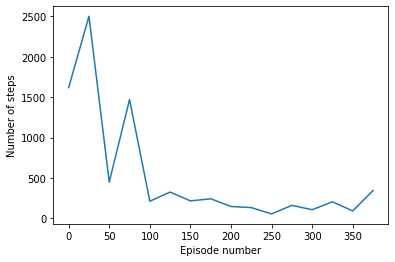

In [ ]:
episodes = [i * K for i in range(len(MC15_episode_steps_counts))]
plt.plot(episodes, MC15_episode_steps_counts)
plt.xlabel("Episode number")
plt.ylabel("Number of steps")
plt.show()

**Q LEARNING**

In [ ]:
MAX_STEP = 2500
NUM_OF_EPISODES = 300
K = 25

env = MazeEnvSample15x15()
env.reset()

algorithm = Algorithm.QLearning
evaluation_method = EvaluationMethod.ActionState

exploration = True
alpha = 0.3
gamma = 1.0
epsilon = 0.25
stochastic_probability = 0.9
is_epsilon_decrease = True



policy_args = PolicyArgs(
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon,
    stochastic_probability=stochastic_probability,
    is_epsilon_decrease=is_epsilon_decrease
)

QL15_episode_steps_counts, QL15_final_policy, QL15_mid_policy = run_policy(env=env,
                                                                algorithm=algorithm,
                                                                evaluation_method=evaluation_method,
                                                                exploration=exploration,
                                                                args=policy_args,
                                                                overwrite_rewards={})

Generated an episode 0 -- took 2500 steps
Generated an episode 25 -- took 2500 steps
Generated an episode 50 -- took 2500 steps
Generated an episode 75 -- took 616 steps
Generated an episode 100 -- took 262 steps
Generated an episode 125 -- took 69 steps
Generated an episode 150 -- took 47 steps
Generated an episode 175 -- took 43 steps
Generated an episode 200 -- took 45 steps
Generated an episode 225 -- took 39 steps
Generated an episode 250 -- took 597 steps
Generated an episode 275 -- took 35 steps


MIDDLE OF EVALUATION RUN

In [ ]:
env = MazeEnvSample15x15()
run(env, QL15_mid_policy, evaluation_method, stochastic_probability, epsilon)

91

END OF EVALUATION RUN

In [ ]:
env = MazeEnvSample15x15()
run(env, QL15_final_policy, evaluation_method, stochastic_probability, epsilon)

43

*Plot of number of steps per episode*

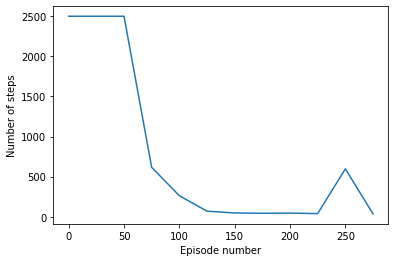

In [ ]:
episodes = [i * K for i in range(len(QL15_episode_steps_counts))]
plt.plot(episodes, QL15_episode_steps_counts)
plt.xlabel("Episode number")
plt.ylabel("Number of steps")
plt.show()

### Environment 30X30

We used the Q-learning algorithm

In [ ]:
MAX_STEP = 4000
NUM_OF_EPISODES = 2500
K = 50

env = MazeEnvSample30x30()
env.reset()

algorithm = Algorithm.QLearning
evaluation_method = EvaluationMethod.ActionState

exploration = True
alpha = 0.3
gamma = 1.0
epsilon = 0.25
stochastic_probability = 0.9
is_epsilon_decrease = True



policy_args = PolicyArgs(
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon,
    stochastic_probability=stochastic_probability,
    is_epsilon_decrease=is_epsilon_decrease
)

QL30_episode_steps_counts, QL30_final_policy, QL30_mid_policy = run_policy(env=env,
                                                          algorithm=algorithm,
                                                          evaluation_method=evaluation_method,
                                                          exploration=exploration,
                                                          args=policy_args,
                                                          overwrite_rewards={})

Generated an episode 0 -- took 4000 steps
Generated an episode 50 -- took 4000 steps
Generated an episode 100 -- took 4000 steps
Generated an episode 150 -- took 4000 steps
Generated an episode 200 -- took 4000 steps
Generated an episode 250 -- took 4000 steps
Generated an episode 300 -- took 1481 steps
Generated an episode 350 -- took 4000 steps
Generated an episode 400 -- took 4000 steps
Generated an episode 450 -- took 4000 steps
Generated an episode 500 -- took 4000 steps
Generated an episode 550 -- took 4000 steps
Generated an episode 600 -- took 4000 steps
Generated an episode 650 -- took 1828 steps
Generated an episode 700 -- took 227 steps
Generated an episode 750 -- took 680 steps
Generated an episode 800 -- took 1132 steps
Generated an episode 850 -- took 382 steps
Generated an episode 900 -- took 172 steps
Generated an episode 950 -- took 1450 steps
Generated an episode 1000 -- took 631 steps
Generated an episode 1050 -- took 151 steps
Generated an episode 1100 -- took 159 s

MIDDLE OF EVALUATION RUN

In [ ]:
env = MazeEnvSample30x30()
run(env, QL30_mid_policy, evaluation_method, stochastic_probability, epsilon)

172

END OF EVALUATION RUN

In [ ]:
env = MazeEnvSample30x30()
run(env, QL30_final_policy, evaluation_method, stochastic_probability, epsilon)

146

Plot of number of steps per episode

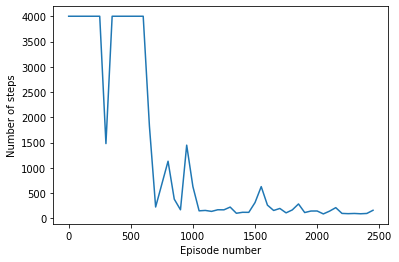

In [ ]:
episodes = [i * K for i in range(len(QL30_episode_steps_counts))]
plt.plot(episodes, QL30_episode_steps_counts)
plt.xlabel("Episode number")
plt.ylabel("Number of steps")
plt.show()